In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_palette("GnBu_d")
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


%matplotlib inline

In [2]:
brm_hourly_driven = pd.read_csv("../generated/brm_hourly_driven.csv")
frb_hourly_driven = pd.read_csv("../generated/frb_hourly_driven.csv")

brm_hourly_weather = pd.read_csv("../generated/brm_hourly_weather.csv")
frb_hourly_weather = pd.read_csv("../generated/frb_hourly_weather.csv")

## Prediction

In [85]:
def merge_duration_and_weather(duration, weather):
    return duration.merge(how="left", left_on=["day", "hour"], right_on=["day","hour"], right=weather)

def timedelta_to_hours(timedelta_array):
    return timedelta_array.map(lambda x: x / pd.Timedelta("1 hour"))

def add_weekday(frame):
    frame["day"] = pd.to_datetime(frame["day"])
    frame["weekday"] = frame["day"].map(lambda x: x.weekday())
    return frame
    
def split_weekday(frame):
    frame = add_weekday(frame)
    weekdays = [None]*7
    for i in range(0,6):
        weekdays[i] = frame[frame["weekday"]==i]
    return weekdays

def regression(frame,frame_model):
    y = frame["trip_duration"]
    X = frame[["temperature","precipitation"]]
    frame_model.fit(X, y)
    predict = frame_model.predict(X)
    return predict

def plot_regression(X,y, predict):
    plt.figure(figsize = (8,6))
    plt.scatter(X, y, marker="x")
    plt.xlabel("temperature in °C")
    plt.ylabel("trip duration in h")
    plt.plot(X, predict, c='C2')
    plt.legend(['Squared loss fit','Observed hours'])


def split(X, y, train_size, validate_size):
    if (train_size+validate_size) <= 1:
        x_train, x_tmp, y_train, y_tmp = train_test_split(X, y, test_size=(1-train_size))
        x_validate, x_test, y_validate, y_test = train_test_split(x_tmp, y_tmp, test_size=(1-validate_size/(1-train_size)))
        return x_train, x_validate, x_test, y_train, y_validate, y_test

    
    
def linear_regression(X, y):

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    model = LinearRegression()
    model.fit(x_train, y_train)
    print("Coefficients ", model.coef_, "\nIntercept ", model.intercept_ )
    predict = model.predict(x_test)
    print("MSE: ", mean_squared_error(y_test, predict))
    print ("R^2: " ,r2_score(y_test, predict))


def polynomial_regression(X, y, degree):

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    model = LinearRegression()
    poly_features = PolynomialFeatures(degree=degree)
    x_poly = poly_features.fit_transform(x_train)
    x_poly_test = poly_features.fit_transform(x_test)
    model.fit(x_poly, y_train)

    print("Coefficients ", model.coef_, "\nIntercept ", model.intercept_ )
    predict = model.predict(x_poly_test)
    print("MSE:", mean_squared_error(y_test, predict))
    print ("R^2: " ,r2_score(y_test, predict))


def ridge_regression(X, y, degree, alpha):

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    poly_features = PolynomialFeatures(degree=degree)
    x_poly = poly_features.fit_transform(x_train)
    x_poly_test = poly_features.fit_transform(x_test)

    model = Ridge(alpha, normalize=True)
    model.fit(x_poly, y_train)
    print("Coefficients ", model.coef_, "\nIntercept ", model.intercept_ )
    predict = model.predict(x_poly_test)
    print("MSE:", mean_squared_error(y_test, predict))



def lasso_regression(X, y, degree, alpha):
    x_train, x_validate, x_test, y_train, y_validate, y_test = split(X, y, train_size=0.6, validate_size=0.2)

    poly_features = PolynomialFeatures(degree=degree)
    x_poly = poly_features.fit_transform(x_train)
    x_poly_validate = poly_features.fit_transform(x_validate)

    model = Lasso(alpha)
    model.fit(x_poly, y_train)

    print("Coefficients ", model.coef_, "\nIntercept ", model.intercept_ )
    predict = model.predict(x_poly_validate)
    print("MSE:", mean_squared_error(y_validate, predict))




In [4]:
frb_hourly = merge_duration_and_weather(frb_hourly_driven, frb_hourly_weather)
frb_hourly["trip_duration"] = timedelta_to_hours(frb_hourly["trip_duration"])

brm_hourly = merge_duration_and_weather(brm_hourly_driven, brm_hourly_weather)
brm_hourly["trip_duration"] = timedelta_to_hours(brm_hourly["trip_duration"])

frb_weekdays = split_weekday(frb_hourly)
brm_weekdays = split_weekday(brm_hourly)

In [5]:
trip_duration = frb_weekdays[0]["trip_duration"]
f1 = frb_weekdays[0]["temperature"]
f2 = frb_weekdays[0]["precipitation"]
f3 = frb_weekdays[0]["hour"]

Example plot for mondays

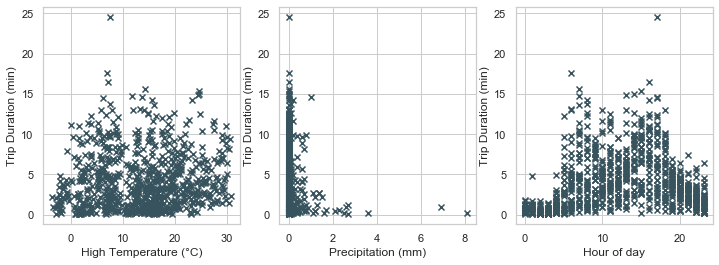

In [6]:
fig = plt.figure(figsize = (12,4))
ax = fig.add_subplot(1,3,1)
ax.scatter(f1,trip_duration, marker='x')
ax.set_xlabel("High Temperature (°C)")
ax.set_ylabel("Trip Duration (min)")
bx =  fig.add_subplot(1,3,2)
bx.scatter(f2,trip_duration, marker='x')
bx.set_xlabel("Precipitation (mm)")
bx.set_ylabel("Trip Duration (min)")
cx =  fig.add_subplot(1,3,3)
cx.scatter(f3,trip_duration, marker='x')
cx.set_xlabel("Hour of day")
cx.set_ylabel("Trip Duration (min)")
plt.show()

In [79]:
#Split

features = frb_hourly[["precipitation", "temperature", "hour"]]
predictor = frb_hourly["trip_duration"]

###  Linear regression

In [83]:
linear_regression(features, predictor)

Coefficients  [-0.38696179  0.02775147  0.0970149 ] 
Intercept  2.382499702591924
MSE:  8.238121723389165
R^2:  -14.348289057359638


### Polynomial regression

In [84]:
polynomial_regression(features, predictor, 3)

Coefficients  [ 0.00000000e+00  9.50668614e-01  1.29393559e-01 -9.30853378e-02
  8.62655636e-01 -2.85634062e-01 -3.72610269e-01 -1.47519514e-02
  2.00921415e-02  5.69517148e-02 -1.60371256e-02 -3.12726739e-02
  4.77386255e-03  1.16503297e-02  3.39817959e-03  1.11827301e-02
  1.84230916e-04  1.71145839e-04 -1.00822107e-03 -2.25520099e-03] 
Intercept  1.6030123575106745
MSE: 9.956761289189462
R^2:  -0.017160847383539846


### Ridge regression

In [16]:
ridge_regression(features, predictor, 3, 0.01)

Coefficients  [ 0.00000000e+00  5.56997034e-02  8.34539295e-02  6.45760277e-01
  9.96840006e-02 -1.37983461e-04 -1.19207372e-01 -6.10382080e-03
  4.91150120e-03  5.77587744e-04 -1.00167457e-02  9.87805295e-03
  4.45089832e-03 -5.12554553e-03 -6.00899501e-03  6.93672836e-03
  3.30370778e-05  1.25445671e-04 -4.39545792e-04 -1.04848893e-03] 
Intercept  0.17762583695402867
MSE: 8.396955289770998


### Lasso regression

In [13]:
ridge_regression(features, predictor, 3, 0.01)

Coefficients  [ 0.00000000e+00  7.85874186e-01  1.23805532e-01  5.83961476e-01
  3.62733811e-01 -3.01105973e-02 -1.88017443e-01 -7.52580900e-03
  7.28025417e-03  1.31228009e-03 -3.06261816e-01  7.22543504e-02
  3.55479328e-02 -9.61974743e-03 -5.86718831e-03  7.08727797e-03
  2.35418011e-05  2.24401358e-04 -5.79685444e-04 -9.74724403e-04] 
Intercept  -0.13896679764729747
MSE: 16.312734819788197


Split the data set into traing(60%), validation(20%), test(20%) setst to prevent leakage.

In [ ]:
x_train, x_validate, x_test = np.split(brm_weekdays[0]['temperature'].sample(frac=1), [int(.6*len(brm_weekdays[0]['temperature'])), int(.8*len(brm_weekdays[0]['temperature']))])
y_train, y_validate, y_test = np.split(brm_weekdays[0]['trip_duration'].sample(frac=1), [int(.6*len(brm_weekdays[0]['trip_duration'])), int(.8*len(brm_weekdays[0]['trip_duration']))])

In [ ]:
plt.scatter(x_train, y_train, label = "Training Data", color = "r", alpha =.7)
plt.scatter(x_test, y_test, label = "Test Data", color = "b", alpha =.7)
plt.scatter(x_validate, y_validate, label = "Validation Data", color = "g", alpha =.7)
plt.legend()
plt.title("Train_Test_Validate Split")
plt.show()

In [ ]:
#Create linear model and train it 
lr = LinearRegression()
lr.fit(x_train.values.reshape(-1, 1), y_train.values)

In [ ]:
# Use model to predict on test data
prediction = lr.predict(x_test.values.reshape(-1, 1))

# Plot prediction line against actual test data 
plt.plot(x_test, prediction, label='Linear Regression', color = 'r')
plt.scatter(x_test, y_test, label='Actual test data', color = 'b', alpha=.7)
plt.legend()
plt.show()

The best score that we could achieve for a model is 1.0. 
~Soo our linear model is not that great...

In [ ]:
# Plot prediction line against actual test data 
prediction = lr.predict(x_validate.values.reshape(-1, 1))
plt.plot(x_validate, prediction, label='Linear Regression', color = 'r')
plt.scatter(x_validate, y_validate, label='Actual test data', color = 'g', alpha=.7)
plt.legend()
plt.show()

In [ ]:
# Score the model 
lr.score(x_validate.values.reshape(-1, 1), y_validate.values)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
y_true = y_validate
y_pred = lr.predict(x_validate.values.reshape((-1,1)))

In [ ]:
print("Mean Squared Error:",mean_squared_error(y_pred, y_true))
print("Root Mean Squared Error:",mean_squared_error(y_pred, y_true)**0.5)
print("Coefficient of determination:",r2_score(y_pred, y_true))

### Polynomial  regression

In [ ]:
from sklearn.preprocessing import PolynomialFeatures


In [ ]:
def plot_regression_poly(X,Y,d):
    
    # initialize PolynomialFeatures
    poly_reg = PolynomialFeatures (degree = d)
    
    # Polynomial transformation
    x_poly = poly_reg.fit_transform(X.reshape(-1,1))
    lin_reg_Poly = LinearRegression()
    
    # Fitting linear regression to polynomial features
    lin_reg_Poly.fit(x_poly, Y)
    model_pred = lin_reg_Poly.predict(x_poly)
    
    # Plotting the regression line and the data (we have to transform the inputs as well!)
    x_fit = np.arange(X.min(),X.max() ,1)[:, np.newaxis]
    y_pred = lin_reg_Poly.predict(poly_reg.fit_transform(x_fit.reshape(-1,1)))
    
    plt.figure(figsize = (8,6))
    plt.scatter(X,Y,marker="o", c='C2')
    ylim = plt.ylim()
    plt.plot(x_fit,y_pred, c='C1')
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Demand (Min)")
    plt.xlim([X.min()-2,X.max()+2]) # leave some space before and after limits
    plt.ylim(ylim)
    print ('The R^2 for quadratic curve is: ',r2_score(Y, model_pred))
    print(lin_reg_Poly.coef_) 

In [ ]:
xp = x_train.values

yp = y_train 

plot_regression_poly(X = xp, Y = yp, d = 4)

In [ ]:
xp = x_test.values

yp = y_test 

plot_regression_poly(X = xp, Y = yp, d = 4)

In [ ]:
xp = x_validate.values

yp = y_validate 

plot_regression_poly(X = xp, Y = yp, d = 4)

In [ ]:
plot_regression_poly

### Idea

Split dataset into train_test_validate sets not for every hour individually but rather hourly.